# Practical 2: GAN & Diffusion

## Task 1

In [220]:
!source lab2_env/bin/activate

In [251]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
import numpy as np
import tqdm
import os
import wandb
from IPython.display import Image, display
import glob

In [252]:
# Hyperparameters
mb_size = 64    # mini‑batch size, num of real/fake samples feedeng through the NN before doing one gradient update
Z_dim = 1000    # dimensionality of the latent noise vector 
h_dim = 128     # size of the hidden layers in both generator and discriminator
lr = 1e-3       # learning rate for the optimizer

We need to normilize out data set to get pixels values from [0, 255] to [0,1] :

PIL:       255  →   Tensor: 1.0

PIL:       128  →   Tensor: 0.50196

PIL:         0  →   Tensor: 0.0

In [253]:
# Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 image to 784
])

train_dataset = datasets.MNIST(root='../MNIST', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=mb_size, shuffle=True)

X_dim = 784  # 28 x 28

Xavier initialization balances weights through layers 
by drawing a random number from a Gaussian (Normal) distribution,
whose mean is 0 and whose standard deviation is chosen according to the layer size.

In [254]:
# Xavier Initialization
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [255]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, h_dim, x_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, x_dim)
        self.apply(xavier_init)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        out = torch.sigmoid(self.fc2(h))   # Sigmoid is possible because data was normalized in [0,1]
        return out

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, x_dim, h_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 1)
        self.apply(xavier_init)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))
        return out

In [256]:
# Training
def cGANTraining(G, D, loss_fn, train_loader):
    G.train()
    D.train()

    D_loss_real_total = 0
    D_loss_fake_total = 0
    G_loss_total = 0
    t = tqdm.tqdm(train_loader)
    
    for it, (X_real, labels) in enumerate(t):
        # Prepare real data
        X_real = X_real.float().to(device)

        # Sample noise and labels
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        ones_label = torch.ones(X_real.size(0), 1).to(device)
        zeros_label = torch.zeros(X_real.size(0), 1).to(device)

        # ================= Train Discriminator =================
        G_sample = G(z)
        D_real = D(X_real)
        D_fake = D(G_sample.detach())  # fake discrimination 

        D_loss_real = loss_fn(D_real, ones_label)
        D_loss_fake = loss_fn(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake
        D_loss_real_total += D_loss_real.item()
        D_loss_fake_total += D_loss_fake.item()

        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()

        # ================= Train Generator ====================
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        G_sample = G(z)
        D_fake = D(G_sample)

        G_loss = loss_fn(D_fake, ones_label)  # more 1 for fakes from D, better for G
        G_loss_total += G_loss.item()

        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()

    # ================= Logging =================
    D_loss_real_avg = D_loss_real_total / len(train_loader)
    D_loss_fake_avg = D_loss_fake_total / len(train_loader)
    D_loss_avg = D_loss_real_avg + D_loss_fake_avg
    G_loss_avg = G_loss_total / len(train_loader)

    """wandb.log({
        "D_loss_real": D_loss_real_avg,
        "D_loss_fake": D_loss_fake_avg,
        "D_loss": D_loss_avg,
        "G_loss": G_loss_avg
    })"""

    return G, D, G_loss_avg, D_loss_avg

In [257]:
# Generator stopps to learn and only generates pictures
def save_sample(G, epoch, mb_size, Z_dim):
    out_dir = "out_vanila_GAN2"
    G.eval()
    with torch.no_grad():
        z = torch.randn(mb_size, Z_dim).to(device)
        samples = G(z).detach().cpu().numpy()[:16]    # We don't need to see all 64, 16 is enough to see progress

    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    if not os.path.exists(f'{out_dir}'):
        os.makedirs(f'{out_dir}')

    plt.savefig(f'{out_dir}/{str(epoch).zfill(3)}.png', bbox_inches='tight')
    plt.close(fig)


In [229]:
# ########################### Training 5 epochs #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of epochs (change only here)
epochs = 5

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function
def my_bce_loss(preds, targets):
    return F.binary_cross_entropy(preds, targets)

loss_fn = my_bce_loss

best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Initialize W&B immediately before training
if wandb_log: 
    wandb.init(
        project="conditional-gan-mnist",
        name=f"run_{epochs}_epochs",
        settings=wandb.Settings(start_method="thread"),
        config={
            "batch_size": mb_size,
            "Z_dim": Z_dim,
            "X_dim": X_dim,
            "h_dim": h_dim,
            "lr": lr,
            "epochs": epochs,
            "start_epoch": 0,
            "end_epoch": epochs - 1
        }
    )

# Train loop
for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg = cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch {epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if wandb_log:
        wandb.log({
            "epoch": epoch,
            "D_loss": D_loss_avg,
            "G_loss": G_loss_avg
        })

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)

# Final log and run closure
if wandb_log:
    wandb.config.update({"final_epoch": epoch})  # saved in config metadata
    wandb.finish()


100%|██████████| 938/938 [00:13<00:00, 67.65it/s]


epoch 0; D_loss: 0.0728; G_loss: 5.8095
Saved Best Models at epoch 0 | G_loss: 5.8095


100%|██████████| 938/938 [00:13<00:00, 67.90it/s]


epoch 1; D_loss: 0.0265; G_loss: 6.1771


100%|██████████| 938/938 [00:13<00:00, 67.63it/s]


epoch 2; D_loss: 0.0414; G_loss: 5.7264
Saved Best Models at epoch 2 | G_loss: 5.7264


100%|██████████| 938/938 [00:13<00:00, 68.44it/s]


epoch 3; D_loss: 0.1024; G_loss: 6.1142


100%|██████████| 938/938 [00:13<00:00, 68.45it/s]


epoch 4; D_loss: 0.1626; G_loss: 5.2521
Saved Best Models at epoch 4 | G_loss: 5.2521


D_loss,▃▁▂▅█
G_loss,▅█▅█▁
epoch,▁▃▅▆█
D_loss,0.16262
G_loss,5.25215
epoch,4


In [230]:
# Inference / sampling from the best‐saved G

# 1) Re‐create the Generator and move to the same device
G_infer = Generator(Z_dim, h_dim, X_dim).to(device)

# 2) Load the weights from the best checkpoint
checkpoint = torch.load('checkpoints/G_best.pth', map_location=device, weights_only=True)
G_infer.load_state_dict(checkpoint)

# 3) Set to evaluation mode
G_infer.eval()

# 4) Generate and save a sample grid (this will create out_vanila_GAN2/best.png)
save_sample(G_infer, "best_5_epochs", mb_size, Z_dim)

# 5) Clean previous best models
for f in glob.glob(os.path.join(save_dir, "G_best_epoch*.pth")):
    os.remove(f)

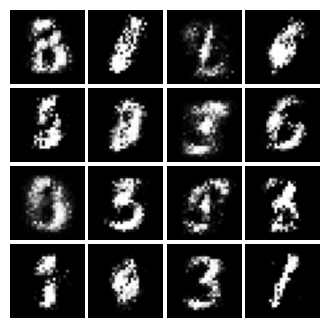

In [231]:
display(Image("best_5_epochs.png"))

In [248]:
# ########################### Training 10 epochs #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of epochs (change only here)
epochs = 10

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function
def my_bce_loss(preds, targets):
    return F.binary_cross_entropy(preds, targets)

loss_fn = my_bce_loss

best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Initialize W&B immediately before training
if wandb_log: 
    wandb.init(
        project="conditional-gan-mnist",
        name=f"run_{epochs}_epochs",
        settings=wandb.Settings(start_method="thread"),
        config={
            "batch_size": mb_size,
            "Z_dim": Z_dim,
            "X_dim": X_dim,
            "h_dim": h_dim,
            "lr": lr,
            "epochs": epochs,
            "start_epoch": 0,
            "end_epoch": epochs - 1
        }
    )

# Train loop
for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg = cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch {epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if wandb_log:
        wandb.log({
            "epoch": epoch,
            "D_loss": D_loss_avg,
            "G_loss": G_loss_avg
        })

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)

# Final log and run closure
if wandb_log:
    wandb.config.update({"final_epoch": epoch})  # saved in config metadata
    wandb.finish()


100%|██████████| 938/938 [00:13<00:00, 67.27it/s]


epoch 0; D_loss: 0.0763; G_loss: 6.3144
Saved Best Models at epoch 0 | G_loss: 6.3144


100%|██████████| 938/938 [00:12<00:00, 77.25it/s] 


epoch 1; D_loss: 0.0332; G_loss: 5.9419
Saved Best Models at epoch 1 | G_loss: 5.9419


100%|██████████| 938/938 [00:11<00:00, 82.50it/s] 


epoch 2; D_loss: 0.0587; G_loss: 5.2664
Saved Best Models at epoch 2 | G_loss: 5.2664


100%|██████████| 938/938 [00:08<00:00, 105.02it/s]


epoch 3; D_loss: 0.1295; G_loss: 5.0989
Saved Best Models at epoch 3 | G_loss: 5.0989


100%|██████████| 938/938 [00:13<00:00, 69.60it/s]


epoch 4; D_loss: 0.2347; G_loss: 4.5078
Saved Best Models at epoch 4 | G_loss: 4.5078


100%|██████████| 938/938 [00:13<00:00, 69.10it/s]


epoch 5; D_loss: 0.3462; G_loss: 4.2113
Saved Best Models at epoch 5 | G_loss: 4.2113


100%|██████████| 938/938 [00:13<00:00, 68.95it/s]


epoch 6; D_loss: 0.4212; G_loss: 3.7142
Saved Best Models at epoch 6 | G_loss: 3.7142


100%|██████████| 938/938 [00:13<00:00, 68.35it/s]


epoch 7; D_loss: 0.5064; G_loss: 3.9919


100%|██████████| 938/938 [00:13<00:00, 68.58it/s]


epoch 8; D_loss: 0.5489; G_loss: 3.2312
Saved Best Models at epoch 8 | G_loss: 3.2312


100%|██████████| 938/938 [00:13<00:00, 71.25it/s] 


epoch 9; D_loss: 0.6059; G_loss: 2.9515
Saved Best Models at epoch 9 | G_loss: 2.9515


D_loss,▂▁▁▂▃▅▆▇▇█
G_loss,█▇▆▅▄▄▃▃▂▁
epoch,▁▂▃▃▄▅▆▆▇█
D_loss,0.6059
G_loss,2.95153
epoch,9


In [249]:
# Inference / sampling from the best‐saved G

# 1) Re‐create the Generator and move to the same device
G_infer = Generator(Z_dim, h_dim, X_dim).to(device)

# 2) Load the weights from the best checkpoint
checkpoint = torch.load('checkpoints/G_best.pth', map_location=device, weights_only=True)
G_infer.load_state_dict(checkpoint)

# 3) Set to evaluation mode
G_infer.eval()

# 4) Generate and save a sample grid (this will create out_vanila_GAN2/best.png)
save_sample(G_infer, "best_10_epochs", mb_size, Z_dim)

# 5) Clean previous best models
for f in glob.glob(os.path.join(save_dir, "G_best_epoch*.pth")):
    os.remove(f)

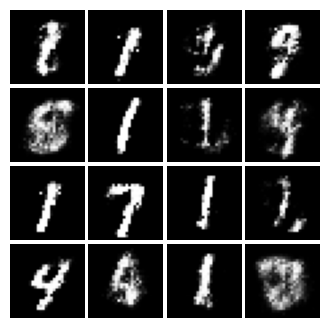

In [250]:
display(Image("best_10_epochs.png"))

In [258]:
# ########################### Training 50 epochs #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of epochs (change only here)
epochs = 50

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function
def my_bce_loss(preds, targets):
    return F.binary_cross_entropy(preds, targets)

loss_fn = my_bce_loss

best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Initialize W&B immediately before training
if wandb_log: 
    wandb.init(
        project="conditional-gan-mnist",
        name=f"run_{epochs}_epochs",
        settings=wandb.Settings(start_method="thread"),
        config={
            "batch_size": mb_size,
            "Z_dim": Z_dim,
            "X_dim": X_dim,
            "h_dim": h_dim,
            "lr": lr,
            "epochs": epochs,
            "start_epoch": 0,
            "end_epoch": epochs - 1
        }
    )

# Train loop
for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg = cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch {epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if wandb_log:
        wandb.log({
            "epoch": epoch,
            "D_loss": D_loss_avg,
            "G_loss": G_loss_avg
        })

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)

# Final log and run closure
if wandb_log:
    wandb.config.update({"final_epoch": epoch})  # saved in config metadata
    wandb.finish()


100%|██████████| 938/938 [00:09<00:00, 103.60it/s]


epoch 0; D_loss: 0.0603; G_loss: 6.3181
Saved Best Models at epoch 0 | G_loss: 6.3181


100%|██████████| 938/938 [00:13<00:00, 69.84it/s]


epoch 1; D_loss: 0.0229; G_loss: 6.8692


100%|██████████| 938/938 [00:13<00:00, 68.01it/s]


epoch 2; D_loss: 0.0516; G_loss: 5.6509
Saved Best Models at epoch 2 | G_loss: 5.6509


100%|██████████| 938/938 [00:13<00:00, 68.57it/s]


epoch 3; D_loss: 0.1201; G_loss: 5.5195
Saved Best Models at epoch 3 | G_loss: 5.5195


100%|██████████| 938/938 [00:13<00:00, 68.71it/s]


epoch 4; D_loss: 0.2669; G_loss: 4.7261
Saved Best Models at epoch 4 | G_loss: 4.7261


100%|██████████| 938/938 [00:13<00:00, 68.37it/s]


epoch 5; D_loss: 0.3641; G_loss: 4.2153
Saved Best Models at epoch 5 | G_loss: 4.2153


100%|██████████| 938/938 [00:13<00:00, 68.47it/s]


epoch 6; D_loss: 0.4373; G_loss: 3.5026
Saved Best Models at epoch 6 | G_loss: 3.5026


100%|██████████| 938/938 [00:13<00:00, 68.61it/s]


epoch 7; D_loss: 0.5208; G_loss: 3.2170
Saved Best Models at epoch 7 | G_loss: 3.2170


100%|██████████| 938/938 [00:13<00:00, 68.39it/s]


epoch 8; D_loss: 0.5915; G_loss: 3.1314
Saved Best Models at epoch 8 | G_loss: 3.1314


100%|██████████| 938/938 [00:13<00:00, 68.13it/s]


epoch 9; D_loss: 0.6437; G_loss: 2.9862
Saved Best Models at epoch 9 | G_loss: 2.9862


100%|██████████| 938/938 [00:13<00:00, 68.87it/s]


epoch 10; D_loss: 0.6754; G_loss: 2.8433
Saved Best Models at epoch 10 | G_loss: 2.8433


100%|██████████| 938/938 [00:13<00:00, 68.70it/s]


epoch 11; D_loss: 0.7469; G_loss: 2.5995
Saved Best Models at epoch 11 | G_loss: 2.5995


100%|██████████| 938/938 [00:13<00:00, 70.67it/s] 


epoch 12; D_loss: 0.7237; G_loss: 2.5353
Saved Best Models at epoch 12 | G_loss: 2.5353


100%|██████████| 938/938 [00:13<00:00, 68.59it/s]


epoch 13; D_loss: 0.7351; G_loss: 2.3914
Saved Best Models at epoch 13 | G_loss: 2.3914


100%|██████████| 938/938 [00:13<00:00, 68.34it/s]


epoch 14; D_loss: 0.7364; G_loss: 2.2754
Saved Best Models at epoch 14 | G_loss: 2.2754


100%|██████████| 938/938 [00:13<00:00, 68.44it/s]


epoch 15; D_loss: 0.7691; G_loss: 2.1396
Saved Best Models at epoch 15 | G_loss: 2.1396


100%|██████████| 938/938 [00:13<00:00, 69.54it/s]


epoch 16; D_loss: 0.7858; G_loss: 1.9920
Saved Best Models at epoch 16 | G_loss: 1.9920


100%|██████████| 938/938 [00:13<00:00, 69.13it/s]


epoch 17; D_loss: 0.7705; G_loss: 1.9950


100%|██████████| 938/938 [00:12<00:00, 77.65it/s] 


epoch 18; D_loss: 0.7729; G_loss: 2.0170


100%|██████████| 938/938 [00:11<00:00, 79.24it/s] 


epoch 19; D_loss: 0.7680; G_loss: 2.0665


100%|██████████| 938/938 [00:13<00:00, 69.14it/s]


epoch 20; D_loss: 0.7795; G_loss: 2.0578


100%|██████████| 938/938 [00:13<00:00, 68.69it/s]


epoch 21; D_loss: 0.7881; G_loss: 1.9644
Saved Best Models at epoch 21 | G_loss: 1.9644


100%|██████████| 938/938 [00:13<00:00, 68.71it/s]


epoch 22; D_loss: 0.7899; G_loss: 1.9836


100%|██████████| 938/938 [00:13<00:00, 68.92it/s]


epoch 23; D_loss: 0.7770; G_loss: 1.9711


100%|██████████| 938/938 [00:13<00:00, 69.06it/s]


epoch 24; D_loss: 0.7702; G_loss: 2.0064


100%|██████████| 938/938 [00:13<00:00, 68.19it/s]


epoch 25; D_loss: 0.7707; G_loss: 2.0489


100%|██████████| 938/938 [00:13<00:00, 68.43it/s]


epoch 26; D_loss: 0.7716; G_loss: 2.0157


100%|██████████| 938/938 [00:13<00:00, 68.39it/s]


epoch 27; D_loss: 0.7667; G_loss: 2.0546


100%|██████████| 938/938 [00:13<00:00, 69.98it/s]


epoch 28; D_loss: 0.7668; G_loss: 2.0120


100%|██████████| 938/938 [00:13<00:00, 68.42it/s]


epoch 29; D_loss: 0.7607; G_loss: 2.0504


100%|██████████| 938/938 [00:13<00:00, 68.56it/s]


epoch 30; D_loss: 0.7506; G_loss: 2.0979


100%|██████████| 938/938 [00:13<00:00, 67.87it/s]


epoch 31; D_loss: 0.7538; G_loss: 2.1101


100%|██████████| 938/938 [00:11<00:00, 80.07it/s] 


epoch 32; D_loss: 0.7394; G_loss: 2.1292


100%|██████████| 938/938 [00:13<00:00, 68.51it/s]


epoch 33; D_loss: 0.7291; G_loss: 2.1526


100%|██████████| 938/938 [00:13<00:00, 68.80it/s]


epoch 34; D_loss: 0.7209; G_loss: 2.1871


100%|██████████| 938/938 [00:13<00:00, 68.32it/s]


epoch 35; D_loss: 0.7159; G_loss: 2.2168


100%|██████████| 938/938 [00:13<00:00, 68.15it/s]


epoch 36; D_loss: 0.7085; G_loss: 2.2616


100%|██████████| 938/938 [00:13<00:00, 68.01it/s]


epoch 37; D_loss: 0.7034; G_loss: 2.2918


100%|██████████| 938/938 [00:13<00:00, 68.17it/s]


epoch 38; D_loss: 0.6946; G_loss: 2.2883


100%|██████████| 938/938 [00:13<00:00, 68.95it/s]


epoch 39; D_loss: 0.6873; G_loss: 2.3585


100%|██████████| 938/938 [00:13<00:00, 68.83it/s]


epoch 40; D_loss: 0.6926; G_loss: 2.3655


100%|██████████| 938/938 [00:12<00:00, 77.45it/s] 


epoch 41; D_loss: 0.6789; G_loss: 2.3457


100%|██████████| 938/938 [00:11<00:00, 84.98it/s] 


epoch 42; D_loss: 0.6805; G_loss: 2.3965


100%|██████████| 938/938 [00:13<00:00, 68.38it/s]


epoch 43; D_loss: 0.6828; G_loss: 2.3778


100%|██████████| 938/938 [00:13<00:00, 68.35it/s]


epoch 44; D_loss: 0.6771; G_loss: 2.3994


100%|██████████| 938/938 [00:13<00:00, 68.03it/s]


epoch 45; D_loss: 0.6785; G_loss: 2.4030


100%|██████████| 938/938 [00:13<00:00, 69.30it/s]


epoch 46; D_loss: 0.6756; G_loss: 2.4321


100%|██████████| 938/938 [00:13<00:00, 68.56it/s]


epoch 47; D_loss: 0.6673; G_loss: 2.4159


100%|██████████| 938/938 [00:13<00:00, 69.06it/s]


epoch 48; D_loss: 0.6703; G_loss: 2.4225


100%|██████████| 938/938 [00:13<00:00, 68.83it/s]


epoch 49; D_loss: 0.6645; G_loss: 2.4467


D_loss,▁▁▂▃▄▅▆▇▇█▇▇██████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇
G_loss,▇█▆▆▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
D_loss,0.66451
G_loss,2.44671
epoch,49


In [259]:
# Inference / sampling from the best‐saved G

# 1) Re‐create the Generator and move to the same device
G_infer = Generator(Z_dim, h_dim, X_dim).to(device)

# 2) Load the weights from the best checkpoint
checkpoint = torch.load('checkpoints/G_best.pth', map_location=device, weights_only=True)
G_infer.load_state_dict(checkpoint)

# 3) Set to evaluation mode
G_infer.eval()

# 4) Generate and save a sample grid (this will create out_vanila_GAN2/best.png)
save_sample(G_infer, "best_50_epochs", mb_size, Z_dim)

# 5) Clean previous best models
for f in glob.glob(os.path.join(save_dir, "G_best_epoch*.pth")):
    os.remove(f)

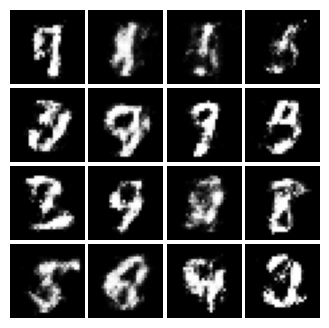

In [260]:
display(Image("best_50_epochs.png"))

In [264]:
# Summary of 5, 10, and 50 epochs
data = {
    "Epochs": [5, 10, 50],
    "D_loss": [0.16262, 0.6059, 0.66451],
    "G_loss": [5.25215, 2.95153, 2.44671],
    "Observation": [
        "D is weak, G is generating random noise — generator loss is very high",
        "G starts to learn, D becomes stronger — training becomes more balanced",
        "D is strong, but G keeps improving — training stabilizes"
    ]
}

df = pd.DataFrame(data)
df

,Epochs,D_loss,G_loss,Observation
0,5,0.16262,5.25215,"D is weak, G is generating random noise — generator loss is very high"
1,10,0.60590,2.95153,"G starts to learn, D becomes stronger — training becomes more balanced"
2,50,0.66451,2.44671,"D is strong, but G keeps improving — training stabilizes"


## Task 2

Run the same code with a different loss function: Logistic loss as described in Brandon
Amos blog and compare the results with above Task 1.

In [277]:
########################################################################
    # Logistic loss. Change "out" in Discriminator and Loss Function
########################################################################
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, h_dim, x_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, x_dim)
        self.apply(xavier_init)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        out = torch.sigmoid(self.fc2(h))   # Sigmoid is possible because data was normalized in [0,1]
        return out

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, x_dim, h_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 1)
        self.apply(xavier_init)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        # out = torch.sigmoid(self.fc2(h))    # before change 
        out = self.fc2(h)                     # after change to logistic loss
        return out

In [278]:
# Training
def cGANTraining(G, D, loss_fn, train_loader):
    G.train()
    D.train()

    D_loss_real_total = 0
    D_loss_fake_total = 0
    G_loss_total = 0
    t = tqdm.tqdm(train_loader)
    
    for it, (X_real, labels) in enumerate(t):
        # Prepare real data
        X_real = X_real.float().to(device)

        # Sample noise and labels
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        ones_label = torch.ones(X_real.size(0), 1).to(device)
        zeros_label = torch.zeros(X_real.size(0), 1).to(device)

        # ================= Train Discriminator =================
        G_sample = G(z)
        D_real = D(X_real)
        D_fake = D(G_sample.detach())  # fake discrimination 

        D_loss_real = loss_fn(D_real, ones_label)
        D_loss_fake = loss_fn(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake
        D_loss_real_total += D_loss_real.item()
        D_loss_fake_total += D_loss_fake.item()

        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()

        # ================= Train Generator ====================
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        G_sample = G(z)
        D_fake = D(G_sample)

        G_loss = loss_fn(D_fake, ones_label)  # more 1 for fakes from D, better for G
        G_loss_total += G_loss.item()

        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()

    # ================= Logging =================
    D_loss_real_avg = D_loss_real_total / len(train_loader)
    D_loss_fake_avg = D_loss_fake_total / len(train_loader)
    D_loss_avg = D_loss_real_avg + D_loss_fake_avg
    G_loss_avg = G_loss_total / len(train_loader)

    """wandb.log({
        "D_loss_real": D_loss_real_avg,
        "D_loss_fake": D_loss_fake_avg,
        "D_loss": D_loss_avg,
        "G_loss": G_loss_avg
    })"""

    return G, D, G_loss_avg, D_loss_avg

In [279]:
# Generator stopps to learn and only generates pictures
def save_sample(G, epoch, mb_size, Z_dim):
    out_dir = "out_vanila_GAN2"
    G.eval()
    with torch.no_grad():
        z = torch.randn(mb_size, Z_dim).to(device)
        samples = G(z).detach().cpu().numpy()[:16]    # We don't need to see all 64, 16 is enough to see progress

    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    if not os.path.exists(f'{out_dir}'):
        os.makedirs(f'{out_dir}')

    plt.savefig(f'{out_dir}/{str(epoch).zfill(3)}.png', bbox_inches='tight')
    plt.close(fig)


In [268]:
########################### 5 epochs #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of epochs (change only here)
epochs = 5

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function

#def my_bce_loss(preds, targets):
#    return F.binary_cross_entropy(preds, targets)
# loss_fn = my_bce_loss                               # Before change

# Binary Cross Entropy loss function 
loss_fn = nn.BCEWithLogitsLoss()                      # After change. Includes Sigmoid by itself


best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Initialize W&B immediately before training
if wandb_log: 
    wandb.init(
        project="conditional-gan-mnist",
        name=f"run_{epochs}_epochs",
        settings=wandb.Settings(start_method="thread"),
        config={
            "batch_size": mb_size,
            "Z_dim": Z_dim,
            "X_dim": X_dim,
            "h_dim": h_dim,
            "lr": lr,
            "epochs": epochs,
            "start_epoch": 0,
            "end_epoch": epochs - 1
        }
    )

# Train loop
for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg = cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch {epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if wandb_log:
        wandb.log({
            "epoch": epoch,
            "D_loss": D_loss_avg,
            "G_loss": G_loss_avg
        })

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)

# Final log and run closure
if wandb_log:
    wandb.config.update({"final_epoch": epoch})  # saved in config metadata
    wandb.finish()

100%|██████████| 938/938 [00:11<00:00, 85.25it/s] 


epoch 0; D_loss: 0.0698; G_loss: 5.8389
Saved Best Models at epoch 0 | G_loss: 5.8389


100%|██████████| 938/938 [00:13<00:00, 70.19it/s]


epoch 1; D_loss: 0.0371; G_loss: 5.9024


100%|██████████| 938/938 [00:13<00:00, 70.47it/s]


epoch 2; D_loss: 0.0430; G_loss: 5.8749


100%|██████████| 938/938 [00:13<00:00, 70.75it/s]


epoch 3; D_loss: 0.0737; G_loss: 5.8346
Saved Best Models at epoch 3 | G_loss: 5.8346


100%|██████████| 938/938 [00:13<00:00, 70.55it/s]


epoch 4; D_loss: 0.1575; G_loss: 5.2952
Saved Best Models at epoch 4 | G_loss: 5.2952


D_loss,▃▁▁▃█
G_loss,▇██▇▁
epoch,▁▃▅▆█
D_loss,0.15751
G_loss,5.29518
epoch,4


In [269]:
# Inference / sampling from the best‐saved G

# 1) Re‐create the Generator and move to the same device
G_infer = Generator(Z_dim, h_dim, X_dim).to(device)

# 2) Load the weights from the best checkpoint
checkpoint = torch.load('checkpoints/G_best.pth', map_location=device, weights_only=True)
G_infer.load_state_dict(checkpoint)

# 3) Set to evaluation mode
G_infer.eval()

# 4) Generate and save a sample grid (this will create out_vanila_GAN2/best.png)
save_sample(G_infer, "best_5_epoch_log", mb_size, Z_dim)

# 5) Clean previous best models
for f in glob.glob(os.path.join(save_dir, "G_best_epoch*.pth")):
    os.remove(f)


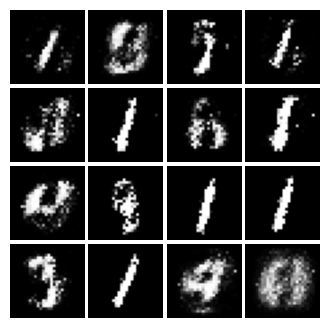

In [270]:
display(Image("best_5_epoch_log.png"))

In [274]:
########################### 10 epochs #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of epochs (change only here)
epochs = 10

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function

#def my_bce_loss(preds, targets):
#    return F.binary_cross_entropy(preds, targets)
# loss_fn = my_bce_loss                               # Before change

# Binary Cross Entropy loss function 
loss_fn = nn.BCEWithLogitsLoss()                      # After change. Includes Sigmoid by itself


best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Initialize W&B immediately before training
if wandb_log: 
    wandb.init(
        project="conditional-gan-mnist",
        name=f"run_{epochs}_epochs",
        settings=wandb.Settings(start_method="thread"),
        config={
            "batch_size": mb_size,
            "Z_dim": Z_dim,
            "X_dim": X_dim,
            "h_dim": h_dim,
            "lr": lr,
            "epochs": epochs,
            "start_epoch": 0,
            "end_epoch": epochs - 1
        }
    )

# Train loop
for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg = cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch {epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if wandb_log:
        wandb.log({
            "epoch": epoch,
            "D_loss": D_loss_avg,
            "G_loss": G_loss_avg
        })

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)

# Final log and run closure
if wandb_log:
    wandb.config.update({"final_epoch": epoch})  # saved in config metadata
    wandb.finish()

100%|██████████| 938/938 [00:13<00:00, 69.90it/s]


epoch 0; D_loss: 0.0705; G_loss: 6.6021
Saved Best Models at epoch 0 | G_loss: 6.6021


100%|██████████| 938/938 [00:13<00:00, 69.75it/s]


epoch 1; D_loss: 0.0377; G_loss: 6.4047
Saved Best Models at epoch 1 | G_loss: 6.4047


100%|██████████| 938/938 [00:13<00:00, 69.43it/s]


epoch 2; D_loss: 0.0661; G_loss: 4.8763
Saved Best Models at epoch 2 | G_loss: 4.8763


100%|██████████| 938/938 [00:13<00:00, 68.70it/s]


epoch 3; D_loss: 0.1142; G_loss: 5.9590


100%|██████████| 938/938 [00:13<00:00, 69.22it/s]


epoch 4; D_loss: 0.2121; G_loss: 4.9313


100%|██████████| 938/938 [00:13<00:00, 69.49it/s]


epoch 5; D_loss: 0.2878; G_loss: 4.4987
Saved Best Models at epoch 5 | G_loss: 4.4987


100%|██████████| 938/938 [00:11<00:00, 79.19it/s] 


epoch 6; D_loss: 0.3831; G_loss: 3.6229
Saved Best Models at epoch 6 | G_loss: 3.6229


100%|██████████| 938/938 [00:13<00:00, 72.12it/s] 


epoch 7; D_loss: 0.4520; G_loss: 3.3634
Saved Best Models at epoch 7 | G_loss: 3.3634


100%|██████████| 938/938 [00:13<00:00, 68.55it/s]


epoch 8; D_loss: 0.5255; G_loss: 3.2161
Saved Best Models at epoch 8 | G_loss: 3.2161


100%|██████████| 938/938 [00:11<00:00, 84.46it/s] 


epoch 9; D_loss: 0.5661; G_loss: 3.0648
Saved Best Models at epoch 9 | G_loss: 3.0648


D_loss,▁▁▁▂▃▄▆▆▇█
G_loss,██▅▇▅▄▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
D_loss,0.56612
G_loss,3.06479
epoch,9


In [275]:
# Inference / sampling from the best‐saved G

# 1) Re‐create the Generator and move to the same device
G_infer = Generator(Z_dim, h_dim, X_dim).to(device)

# 2) Load the weights from the best checkpoint
checkpoint = torch.load('checkpoints/G_best.pth', map_location=device, weights_only=True)
G_infer.load_state_dict(checkpoint)

# 3) Set to evaluation mode
G_infer.eval()

# 4) Generate and save a sample grid (this will create out_vanila_GAN2/best.png)
save_sample(G_infer, "best_10_epoch_log", mb_size, Z_dim)

# 5) Clean previous best models
for f in glob.glob(os.path.join(save_dir, "G_best_epoch*.pth")):
    os.remove(f)


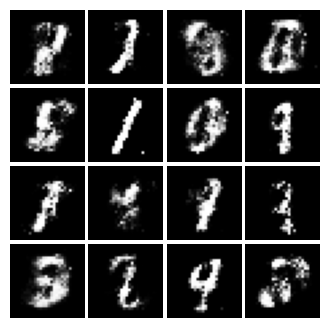

In [276]:
display(Image("best_10_epoch_log.png"))

In [280]:
########################### 50 epochs #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of epochs (change only here)
epochs = 50

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function

#def my_bce_loss(preds, targets):
#    return F.binary_cross_entropy(preds, targets)
# loss_fn = my_bce_loss                               # Before change

# Binary Cross Entropy loss function 
loss_fn = nn.BCEWithLogitsLoss()                      # After change. Includes Sigmoid by itself


best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Initialize W&B immediately before training
if wandb_log: 
    wandb.init(
        project="conditional-gan-mnist",
        name=f"run_{epochs}_epochs",
        settings=wandb.Settings(start_method="thread"),
        config={
            "batch_size": mb_size,
            "Z_dim": Z_dim,
            "X_dim": X_dim,
            "h_dim": h_dim,
            "lr": lr,
            "epochs": epochs,
            "start_epoch": 0,
            "end_epoch": epochs - 1
        }
    )

# Train loop
for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg = cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch {epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if wandb_log:
        wandb.log({
            "epoch": epoch,
            "D_loss": D_loss_avg,
            "G_loss": G_loss_avg
        })

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)

# Final log and run closure
if wandb_log:
    wandb.config.update({"final_epoch": epoch})  # saved in config metadata
    wandb.finish()

100%|██████████| 938/938 [00:11<00:00, 80.27it/s] 


epoch 0; D_loss: 0.0801; G_loss: 6.1297
Saved Best Models at epoch 0 | G_loss: 6.1297


100%|██████████| 938/938 [00:13<00:00, 71.63it/s]


epoch 1; D_loss: 0.0287; G_loss: 6.4285


100%|██████████| 938/938 [00:13<00:00, 71.70it/s]


epoch 2; D_loss: 0.0396; G_loss: 5.3213
Saved Best Models at epoch 2 | G_loss: 5.3213


100%|██████████| 938/938 [00:13<00:00, 71.48it/s]


epoch 3; D_loss: 0.0634; G_loss: 6.1338


100%|██████████| 938/938 [00:10<00:00, 90.35it/s] 


epoch 4; D_loss: 0.1297; G_loss: 5.4396


100%|██████████| 938/938 [00:09<00:00, 103.53it/s]


epoch 5; D_loss: 0.2318; G_loss: 4.7302
Saved Best Models at epoch 5 | G_loss: 4.7302


100%|██████████| 938/938 [00:11<00:00, 79.54it/s] 


epoch 6; D_loss: 0.3628; G_loss: 4.0850
Saved Best Models at epoch 6 | G_loss: 4.0850


100%|██████████| 938/938 [00:11<00:00, 79.35it/s] 


epoch 7; D_loss: 0.4701; G_loss: 3.6352
Saved Best Models at epoch 7 | G_loss: 3.6352


100%|██████████| 938/938 [00:13<00:00, 68.52it/s]


epoch 8; D_loss: 0.5450; G_loss: 2.9766
Saved Best Models at epoch 8 | G_loss: 2.9766


100%|██████████| 938/938 [00:13<00:00, 69.14it/s]


epoch 9; D_loss: 0.5805; G_loss: 2.7689
Saved Best Models at epoch 9 | G_loss: 2.7689


100%|██████████| 938/938 [00:13<00:00, 70.69it/s]


epoch 10; D_loss: 0.6001; G_loss: 2.6890
Saved Best Models at epoch 10 | G_loss: 2.6890


100%|██████████| 938/938 [00:13<00:00, 70.14it/s]


epoch 11; D_loss: 0.6291; G_loss: 2.5780
Saved Best Models at epoch 11 | G_loss: 2.5780


100%|██████████| 938/938 [00:13<00:00, 69.20it/s]


epoch 12; D_loss: 0.6260; G_loss: 2.5255
Saved Best Models at epoch 12 | G_loss: 2.5255


100%|██████████| 938/938 [00:13<00:00, 70.02it/s]


epoch 13; D_loss: 0.6433; G_loss: 2.3543
Saved Best Models at epoch 13 | G_loss: 2.3543


100%|██████████| 938/938 [00:13<00:00, 69.53it/s]


epoch 14; D_loss: 0.6617; G_loss: 2.3475
Saved Best Models at epoch 14 | G_loss: 2.3475


100%|██████████| 938/938 [00:10<00:00, 87.98it/s] 


epoch 15; D_loss: 0.6658; G_loss: 2.2909
Saved Best Models at epoch 15 | G_loss: 2.2909


100%|██████████| 938/938 [00:09<00:00, 99.73it/s] 


epoch 16; D_loss: 0.6726; G_loss: 2.2688
Saved Best Models at epoch 16 | G_loss: 2.2688


100%|██████████| 938/938 [00:09<00:00, 94.81it/s] 


epoch 17; D_loss: 0.6761; G_loss: 2.2382
Saved Best Models at epoch 17 | G_loss: 2.2382


100%|██████████| 938/938 [00:13<00:00, 69.99it/s]


epoch 18; D_loss: 0.6792; G_loss: 2.2252
Saved Best Models at epoch 18 | G_loss: 2.2252


100%|██████████| 938/938 [00:13<00:00, 69.09it/s]


epoch 19; D_loss: 0.6788; G_loss: 2.2586


100%|██████████| 938/938 [00:13<00:00, 69.96it/s]


epoch 20; D_loss: 0.6702; G_loss: 2.2447


100%|██████████| 938/938 [00:13<00:00, 69.71it/s]


epoch 21; D_loss: 0.6726; G_loss: 2.2680


100%|██████████| 938/938 [00:13<00:00, 68.74it/s]


epoch 22; D_loss: 0.6592; G_loss: 2.2858


100%|██████████| 938/938 [00:13<00:00, 70.16it/s]


epoch 23; D_loss: 0.6415; G_loss: 2.3395


100%|██████████| 938/938 [00:13<00:00, 71.15it/s]


epoch 24; D_loss: 0.6367; G_loss: 2.3796


100%|██████████| 938/938 [00:13<00:00, 70.58it/s]


epoch 25; D_loss: 0.6414; G_loss: 2.4140


100%|██████████| 938/938 [00:10<00:00, 91.85it/s] 


epoch 26; D_loss: 0.6361; G_loss: 2.4453


100%|██████████| 938/938 [00:13<00:00, 71.13it/s]


epoch 27; D_loss: 0.6392; G_loss: 2.4936


100%|██████████| 938/938 [00:13<00:00, 69.67it/s]


epoch 28; D_loss: 0.6340; G_loss: 2.5164


100%|██████████| 938/938 [00:10<00:00, 91.78it/s] 


epoch 29; D_loss: 0.6359; G_loss: 2.5610


100%|██████████| 938/938 [00:13<00:00, 69.52it/s]


epoch 30; D_loss: 0.6399; G_loss: 2.5156


100%|██████████| 938/938 [00:09<00:00, 104.00it/s]


epoch 31; D_loss: 0.6370; G_loss: 2.5607


100%|██████████| 938/938 [00:13<00:00, 70.11it/s]


epoch 32; D_loss: 0.6319; G_loss: 2.5698


100%|██████████| 938/938 [00:13<00:00, 69.30it/s]


epoch 33; D_loss: 0.6222; G_loss: 2.5830


100%|██████████| 938/938 [00:13<00:00, 69.60it/s]


epoch 34; D_loss: 0.6108; G_loss: 2.6268


100%|██████████| 938/938 [00:13<00:00, 69.53it/s]


epoch 35; D_loss: 0.6158; G_loss: 2.6148


100%|██████████| 938/938 [00:13<00:00, 70.35it/s]


epoch 36; D_loss: 0.6089; G_loss: 2.6551


100%|██████████| 938/938 [00:13<00:00, 69.74it/s]


epoch 37; D_loss: 0.5954; G_loss: 2.6864


100%|██████████| 938/938 [00:13<00:00, 69.30it/s]


epoch 38; D_loss: 0.5889; G_loss: 2.6836


100%|██████████| 938/938 [00:12<00:00, 72.19it/s] 


epoch 39; D_loss: 0.5867; G_loss: 2.7316


100%|██████████| 938/938 [00:13<00:00, 69.22it/s]


epoch 40; D_loss: 0.5808; G_loss: 2.7682


100%|██████████| 938/938 [00:13<00:00, 69.84it/s]


epoch 41; D_loss: 0.5710; G_loss: 2.8172


100%|██████████| 938/938 [00:13<00:00, 69.80it/s]


epoch 42; D_loss: 0.5709; G_loss: 2.7999


100%|██████████| 938/938 [00:13<00:00, 69.54it/s]


epoch 43; D_loss: 0.5644; G_loss: 2.7792


100%|██████████| 938/938 [00:13<00:00, 69.73it/s]


epoch 44; D_loss: 0.5586; G_loss: 2.8180


100%|██████████| 938/938 [00:13<00:00, 69.57it/s]


epoch 45; D_loss: 0.5505; G_loss: 2.8043


100%|██████████| 938/938 [00:13<00:00, 70.03it/s]


epoch 46; D_loss: 0.5444; G_loss: 2.8249


100%|██████████| 938/938 [00:13<00:00, 68.81it/s]


epoch 47; D_loss: 0.5408; G_loss: 2.8133


100%|██████████| 938/938 [00:13<00:00, 69.92it/s]


epoch 48; D_loss: 0.5423; G_loss: 2.8162


100%|██████████| 938/938 [00:13<00:00, 69.25it/s]


epoch 49; D_loss: 0.5390; G_loss: 2.8421


D_loss,▂▁▁▁▂▅▆▇▇▇███████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆
G_loss,██▆█▆▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
D_loss,0.53903
G_loss,2.84214
epoch,49


In [281]:
# Inference / sampling from the best‐saved G

# 1) Re‐create the Generator and move to the same device
G_infer = Generator(Z_dim, h_dim, X_dim).to(device)

# 2) Load the weights from the best checkpoint
checkpoint = torch.load('checkpoints/G_best.pth', map_location=device, weights_only=True)
G_infer.load_state_dict(checkpoint)

# 3) Set to evaluation mode
G_infer.eval()

# 4) Generate and save a sample grid (this will create out_vanila_GAN2/best.png)
save_sample(G_infer, "best_50_epoch_log", mb_size, Z_dim)

# 5) Clean previous best models
for f in glob.glob(os.path.join(save_dir, "G_best_epoch*.pth")):
    os.remove(f)


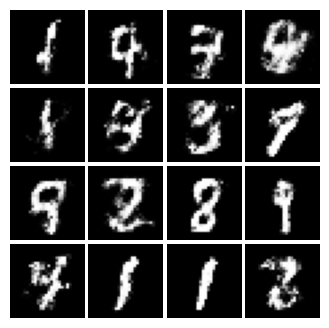

In [282]:
display(Image("best_50_epoch_log.png"))

Two Loss Functions:


**Manual BCE**
→ F.binary_cross_entropy(torch.sigmoid(logits), targets)


**Logistic (recommended)**
→ nn.BCEWithLogitsLoss() (more stable, fused sigmoid + BCE)

###  Results Comparison (5, 10, 50 epochs)

| Epochs | Loss Function   | D_loss  | G_loss  | Observations                                                             |
|--------|------------------|---------|---------|---------------------------------------------------------------------------|
| 5      | Manual BCE       | 0.1626  | 5.2521  | D is weak, G is still producing random-ish noise                         |
|        | BCEWithLogits    | 0.1575  | 5.2952  | Nearly identical — both in early unstable phase                          |
| 10     | Manual BCE       | 0.6059  | 2.9515  | D gets stronger, G starts adapting                                       |
|        | BCEWithLogits    | 0.5661  | 3.0648  | Similar behavior, but slightly smoother G_loss                           |
| 50     | Manual BCE       | 0.6645  | 2.4467  | D overpowers G a bit, generator loss flattens                            |
|        | BCEWithLogits    | 0.5390  | 2.8421  | D is more stable, G still improving — better balance                     |


**nn.BCEWithLogitsLoss()** — offers smoother gradients, better training balance, and is the standard in modern GANs.